># **LightGBM Regression Model**
>
>The dataframe used in this notebook originates from the preprocessing steps 
>performed in the `"1_4b-preprocessing-feature-engineering-and-preprocessing-for-predictive-models.ipynb"` notebook.
>The final refinement of selected variables is conducted here to meet the 
>specific requirements of the models being developed, based on insights from 
>the aforementioned notebook.

In [ ]:
# Importing Required Libraries

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Loading the Dataset and Handling Missing Values of Y

df = pd.read_csv("model_prediction_data.csv", index_col = 0, sep = ",")
df = df.dropna(subset = ["electric_energy_consumption"])

In [6]:
df.head()

,mass_vehicle,weltp_test_mass,engine_capacity,engine_power,erwltp,year,electric_range,fuel_consumption,specific_co2_emissions,innovative_technologies,fuel_type,fuel_mode,electric_energy_consumption
ID,,,,,,,,,,,,,
56003309,1710.0,1817.0,2487.0,131.0,0.0,2021,0.0,5.7,128.0,NonTech,petrol,H,0.0
56003313,1710.0,1817.0,2487.0,131.0,0.0,2021,0.0,5.7,128.0,NonTech,petrol,H,0.0
56003314,1710.0,1817.0,2487.0,131.0,0.0,2021,0.0,5.7,128.0,NonTech,petrol,H,0.0
56003351,1635.0,1749.0,1987.0,129.0,0.0,2021,0.0,7.1,160.0,NonTech,petrol,M,0.0
56003352,1635.0,1749.0,1987.0,129.0,0.0,2021,0.0,7.1,160.0,NonTech,petrol,M,0.0


In [ ]:
# Separate features and target
x = df.drop(columns=["electric_energy_consumption"])
y = df["electric_energy_consumption"]

In [ ]:
# Transform categorical variables
categorical_features = ["fuel_mode", "fuel_type", "innovative_technologies"]
for col in categorical_features:
    x[col] = x[col].astype("category")

In [ ]:
# Splitting Data into Training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create LightGBM datasets
train_data = lgb.Dataset(x_train, label = y_train, categorical_feature = categorical_features)
valid_data = lgb.Dataset(x_test, label = y_test, categorical_feature = categorical_features)

In [ ]:
# Basic parameters + optimizations for large datasets
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.75,
    "bagging_freq": 5,
    "save_binary": True,
    "save_period": 50
}

In [ ]:
# Training with early stopping, checkpoint, and logging
model = lgb.train(
    params,
    train_data,
    valid_sets = [train_data, valid_data],
    valid_names = ["train", "valid"],
    num_boost_round = 1000,
    init_model = None,
    callbacks = [
        lgb.log_evaluation(period = 10),
        lgb.reset_parameter(learning_rate = lambda iter: 0.05 * (0.99 ** iter)),
        lgb.early_stopping(stopping_rounds = 50)
    ]
)

# Save the final model
model.save_model("final_lgbm_model.txt")


Training until validation scores don't improve for 50 rounds
[10]	train's rmse: 32.9625	valid's rmse: 32.9666
[20]	train's rmse: 21.4833	valid's rmse: 21.4846
[30]	train's rmse: 14.7901	valid's rmse: 14.7878
[40]	train's rmse: 10.7722	valid's rmse: 10.7646
[50]	train's rmse: 8.31426	valid's rmse: 8.30187
[60]	train's rmse: 6.78409	valid's rmse: 6.76645
[70]	train's rmse: 5.8189	valid's rmse: 5.79569
[80]	train's rmse: 5.20441	valid's rmse: 5.17736
[90]	train's rmse: 4.80608	valid's rmse: 4.77611
[100]	train's rmse: 4.545	valid's rmse: 4.51285
[110]	train's rmse: 4.36698	valid's rmse: 4.33346
[120]	train's rmse: 4.241	valid's rmse: 4.20659
[130]	train's rmse: 4.14915	valid's rmse: 4.11449
[140]	train's rmse: 4.08283	valid's rmse: 4.048
[150]	train's rmse: 4.03277	valid's rmse: 3.99777
[160]	train's rmse: 3.99333	valid's rmse: 3.95842
[170]	train's rmse: 3.96189	valid's rmse: 3.92699
[180]	train's rmse: 3.9365	valid's rmse: 3.90206
[190]	train's rmse: 3.91596	valid's rmse: 3.88171
[200]	

In [ ]:
# Load saved model
model = lgb.Booster(model_file = "model_lgbm_final.txt")


In [ ]:
# Prediction
from sklearn.metrics import mean_squared_error

y_pred = model.predict(x_test, num_iteration = model.best_iteration)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 3.7527158966849328


In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("R²:", r2)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


R²: 0.9950671616059913
MAE: 0.5034369044940272
MSE: 14.082876601231797
RMSE: 3.7527158966849328


In [ ]:
# Predict on training set
y_pred_train = model.predict(x_train)

# Training set evaluation
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_r2 = r2_score(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_pred_train)

print(f"Train R²: {train_r2:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")


Train R²: 0.9950
Train MAE: 0.5025
Train MSE: 14.3152
Train RMSE: 3.7835


In [ ]:
# Features Importance

importances = model.feature_importance()
features = x_test.columns
feature_importance_dict = dict(zip(features, importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key = lambda x: x[1], reverse = True)

for feat, score in sorted_feature_importance:
    print(f"{feat}: {score}")


electric_range: 11016
specific_co2_emissions: 8914
fuel_consumption: 8713
weltp_test_mass: 8377
mass_vehicle: 8301
engine_power: 6276
year: 5175
engine_capacity: 4582
fuel_type: 536
fuel_mode: 110
erwltp: 0
innovative_technologies: 0


In [15]:
# Electric Energy Consumption Mean

nonzero_mean = df.loc[df["electric_energy_consumption"] != 0, "electric_energy_consumption"].mean()
print("Electric Energy Consumption Mean):", nonzero_mean)



Electric Energy Consumption Mean): 182.39659069473447


### Analysis of the Results

**Train Set Evaluation:**  
- **R² Score:** 0.9950  
- **Mean Absolute Error:** 0.5025  
- **Mean Squared Error:** 14.3152  
- **Root Mean Squared Error:** 3.7835  

**Test Set Evaluation:**  
- **R² Score:** 0.9951  
- **Mean Absolute Error:** 0.5034  
- **Mean Squared Error:** 14.0829  
- **Root Mean Squared Error:** 3.7527  

**Additional Insight:**  
- **Mean Electric Energy Consumption (excluding zeros):** 182.3966  

The evaluation metrics for both the training and test sets indicate **excellent model performance**. With R² scores very close to 0.995, the model explains more than 99.5% of the variability in electric energy consumption. The low MAE, MSE, and RMSE values confirm the high accuracy of the predictions. Moreover, the nearly identical performance between the training and test sets suggests **strong generalization** and no significant signs of overfitting. These results validate the robustness of the LightGBM model in this context.

It is also worth highlighting that the model appears to be reaching **the practical upper bound of performance** given the structure and information available in the current dataset. Gains beyond this level may be increasingly marginal, especially when using purely tabular features, reinforcing the quality of the model’s fit.

In addition, LightGBM achieved this level of performance with remarkable computational efficiency. Its fast training, native handling of categorical features, and ability to model complex non-linear relationships without explicit feature engineering make it highly suitable for large-scale regression tasks such as this one.

### RMSE Analysis in Context of Electric Energy Consumption Scale

The average electric energy consumption (excluding zeros) is approximately 182.4. With a test set RMSE of about 3.75, the model’s predictions deviate on average by roughly **2.1%** relative to the mean consumption (3.75 / 182.4 ≈ 0.0206). This indicates that, on average, the prediction error is **very small** compared to the scale of the target variable.

**Overall, although the low RMSE suggests robust model performance, further analysis is warranted to confirm that the error is consistently low across all observations.**

### Comparing RMSE and MAE in the Context of the Target Scale

Given the average electric energy consumption of approximately 182.4, we observe the following:

- **RMSE (≈ 3.75):**  
  This metric indicates that, on average, the squared error leads to a deviation of about **2.1%** relative to the scale of the target. RMSE is particularly sensitive to larger errors, which suggests that there may be a few predictions with considerably higher deviations that inflate this value.

- **MAE (≈ 0.50):**  
  The Mean Absolute Error shows an average deviation of about **0.27%** relative to the target's scale. This much lower value implies that **most predictions are very close to the actual values**, and the typical error is minimal.

**Interpretation:**  
The notable discrepancy between RMSE and MAE indicates that while the majority of the predictions are highly accurate (as evidenced by the low MAE), there are some larger errors that disproportionately affect the RMSE.

**Interpretation of the Difference and its possible meaning:**  
- The fact that RMSE is notably larger than MAE suggests that, although most predictions are extremely accurate, **a few outliers or extreme cases contribute more heavily to the total error**.  
- This discrepancy highlights the presence of **occasional larger deviations**, which may deserve further investigation in future refinement phases.


C:\Users\leone\AppData\Local\Temp\ipykernel_27544\2198403459.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


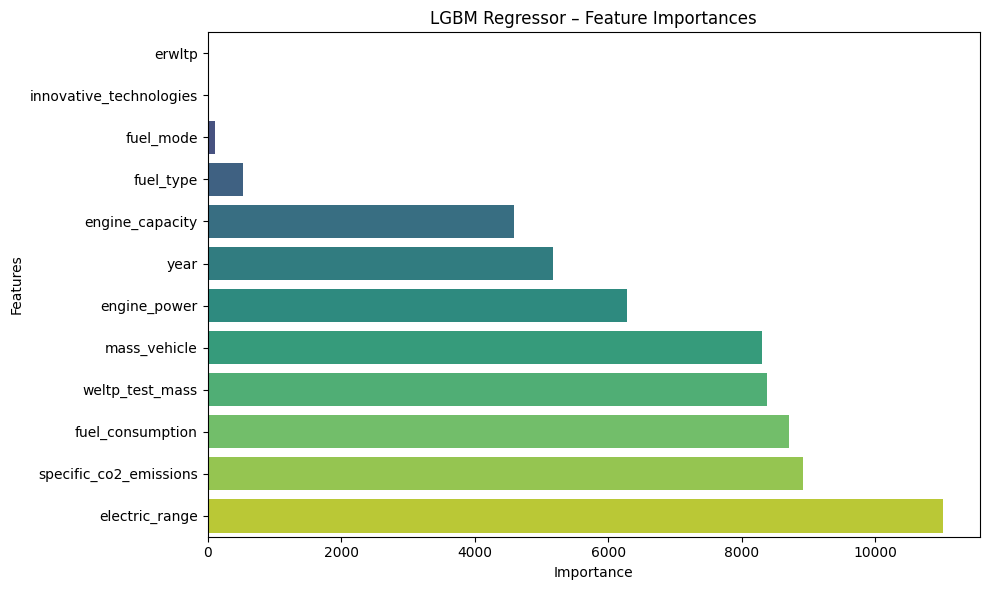

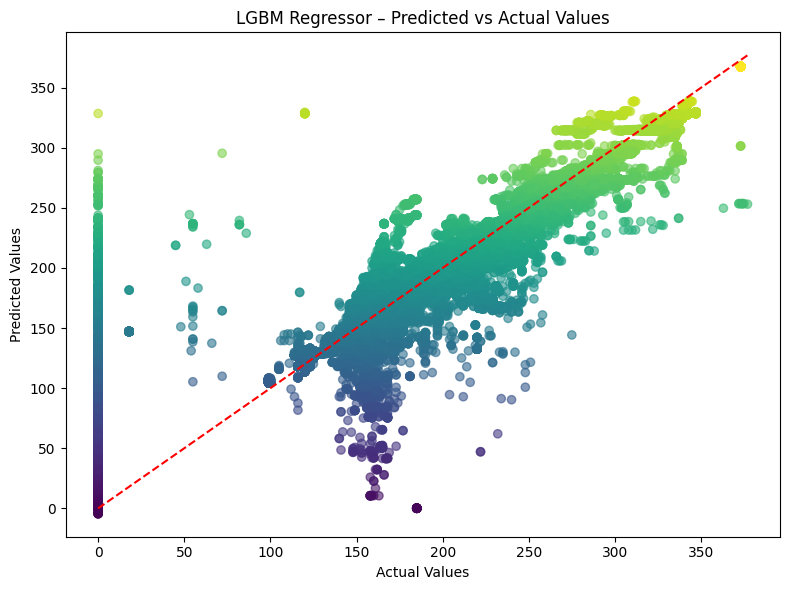

In [ ]:
# Correct for Booster
importances = model.feature_importance()
feature_names = x_train.columns

# Sort by importance
sorted_idx = np.argsort(importances)

# Feature Importance Plot
plt.figure(figsize = (10, 6))
sns.barplot(
    x = importances[sorted_idx],
    y = np.array(feature_names)[sorted_idx],
    palette = "viridis"
)
plt.title("LGBM Regressor – Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Predictions
y_pred = model.predict(x_test)

# Predicted vs Actual Plot
plt.figure(figsize = (8, 6))
plt.scatter(y_test, y_pred, c = y_pred, cmap = "viridis", alpha = 0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color = "red")
plt.title("LGBM Regressor – Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.tight_layout()
plt.show()


### Feature Importance Analysis

> The bar chart shows that **`electric_range`**, **`specific_co2_emissions`**, and **`fuel_consumption`** are the top three features driving the model’s predictions. These results suggest that both electric system capacity and traditional efficiency metrics (such as CO₂ emissions and fuel consumption) are closely linked to electric energy usage.
>
> Other features like **`mass_vehicle`**, **`engine_power`**, and **`year`** also contribute meaningfully to the model, reflecting the interaction between vehicle design, temporal evolution, and performance. Meanwhile, categorical indicators such as **`fuel_type`**, **`fuel_mode`**, and **`innovative_technologies`** show negligible impact, likely because their information is either redundant or less directly connected to the numerical estimation of electric energy consumption.

**Key Observations:**
- **`electric_range`** being the most influential feature confirms that vehicles with extended range often have optimized energy systems or larger batteries that influence consumption.  
- **`specific_co2_emissions`** and **`fuel_consumption`** demonstrate that even in a dataset focused on electric energy, **traditional combustion efficiency indicators remain relevant**, especially in hybrid vehicles.  
- **`mass_vehicle`** and **`engine_power`** align with intuitive expectations: heavier and more powerful vehicles tend to demand more energy.

### Predicted vs. Actual Values

The scatter plot shows a **strong alignment along the diagonal**, confirming the model's ability to capture the relationship between vehicle attributes and electric energy consumption. Some dispersion is noticeable at **higher consumption levels**, suggesting that **extreme cases or outliers introduce greater variance**. Nevertheless, the overall distribution indicates **solid predictive performance**, with well-captured mid-range values and limited bias.

---

### Key Insights on Top Variables

> **Electric Range:**  
> - Represents the battery system’s capacity and efficiency.  
> - Higher electric range generally reflects better energy optimization, and its importance reinforces its predictive power in determining actual consumption.

> **Specific CO2 Emissions:**  
> - While more typical for combustion analysis, this metric correlates with general efficiency in hybrid systems.  
> - In electric-heavy or plug-in hybrid vehicles, it may serve as a proxy for how much the combustion component is still active.

> **Fuel Consumption:**  
> - Even when electric consumption is the target, fuel efficiency metrics remain relevant due to the interplay between electric and fuel-based propulsion.  
> - This is particularly true in transitional technologies and hybrid architectures.

> **Mass Vehicle:**  
> - As expected, vehicle weight has a strong effect on energy demand.  
> - Heavier cars require more power for acceleration and steady motion, leading to higher overall consumption.